In [81]:
import pandas as pd
import numpy as np
from astropy.io import fits,ascii
from astropy.coordinates import SkyCoord,Distance,Angle,match_coordinates_sky,match_coordinates_3d
import astropy.constants as const
from astropy.table import QTable,join,Table, join_skycoord
import astropy.units as u
from astropy.cosmology import default_cosmology
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9
import seaborn as sns 
cosmo = default_cosmology.get()

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

TNS Survey Data containing TDE, TDE-H + He



In [83]:
tns1 = pd.read_csv('tns_search_tde.csv')
tns2 = pd.read_csv('tns_search_tde1.csv')
tnshhe = pd.read_csv('tns_search_tdehhe.csv')
tns_data = pd.concat([tns1,tns2,tnshhe])
tns_data = QTable.from_pandas(tns_data)
tns_data['Coordinates'] = SkyCoord(ra = tns_data["RA"], dec = tns_data["DEC"], unit = (u.hourangle,u.deg), distance = Distance(z = tns_data["Redshift"]))
#tns_data

c:\Users\Chinmay A\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


In [ ]:
tns_3d = tns_data['Name','RA','DEC','Redshift']
tns =tns_3d.to_pandas()
tns = tns.dropna()

tns = QTable.from_pandas(tns)
tns['Coordinates'] = SkyCoord(ra = tns["RA"], dec = tns["DEC"], unit = (u.hourangle,u.deg), distance = Distance(z = tns["Redshift"]))
tns


In [ ]:
tns_data

NSA Data of Galaxies

In [70]:
nsa_data = QTable.read('nsa_v0_1_2.fits')
nsa_data["Coordinates"] = SkyCoord(ra = nsa_data["RA"], dec = nsa_data["DEC"], unit = (u.deg,u.deg), distance = Distance(z = nsa_data["ZDIST"]))

In [ ]:
nsa_data

Cross Matching the data


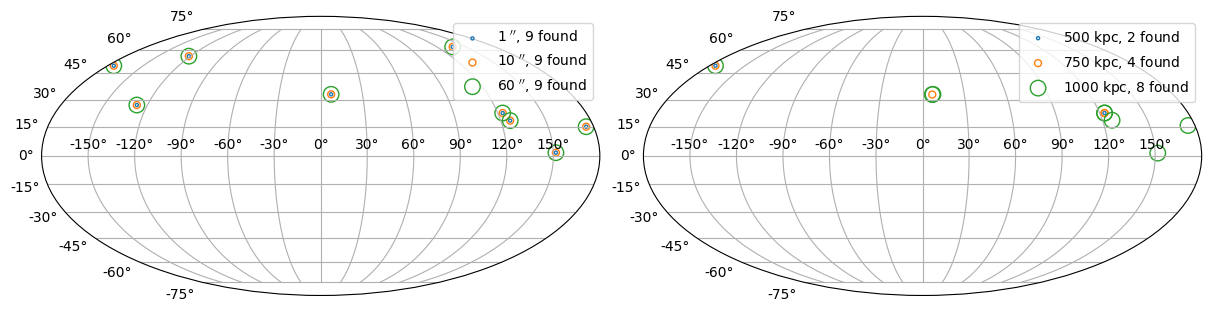

In [80]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12, 4), 
                             constrained_layout=True, 
                             subplot_kw={'projection': "mollweide"})

max_seps = [1, 10, 60] * u.arcsec
max_dists = [500,750,1000]*u.kpc
#2D Separation 
for i, max_sep in enumerate(max_seps):
    idx, d2d, d3d = nsa_data['Coordinates'].match_to_catalog_sky(tns_data['Coordinates'])
    sep_constraint = d2d < max_sep
    matches = nsa_data[sep_constraint]
    #print(len(matches))
    ra = Angle(matches['Coordinates'].ra).wrap_at(180*u.deg)
    dec = Angle(matches['Coordinates'].dec)
    ax1.scatter(ra.radian, dec.radian, 
                alpha=1, s=5 ** (i + 1),
                color='none', edgecolor=f"C{i}",
                label=f"{max_sep:latex_inline}, {len(matches)} found")
ax1.legend()
ax1.grid(True)
#3D Separation 
for i, max_dist  in enumerate(max_dists):
    idx,d2d,d3d = nsa_data['Coordinates'].match_to_catalog_3d(tns['Coordinates'])
    dist_constraint = d3d < max_dist
    matches = nsa_data[dist_constraint]
    ra = Angle(matches['Coordinates'].ra).wrap_at(180*u.deg)
    dec = Angle(matches['Coordinates'].dec)
    ax2.scatter(ra.radian, dec.radian, 
                alpha=1, s=5 ** (i + 1),
                color='none', edgecolor=f"C{i}",
                label=f"{max_dist:latex_inline}, {len(matches)} found")
ax2.legend()
ax2.grid(True)


In [87]:
host_tab = join(tns_data, nsa_data, keys='Coordinates', join_funcs={'Coordinates': join_skycoord(1 * u.arcsec)})
host_tab.rename_columns(['Name', 'IAUNAME'], ['TDE Name', 'Galaxy Name'])
host_tab['TDE Name', 'Galaxy Name']

TDE Name,Galaxy Name
str11,bytes19
AT 2023clx,J114009.39+151938.3
AT 2022dbl,J122045.05+493304.8
AT 2022bdw,J082510.35+183457.5
AT 2021nwa,J155351.26+553520.0
AT 2020wey,J090525.86+614809.4
AT 2020vwl,J153037.80+265856.8
AT 2019azh,J081316.94+223853.8
AT 2018hyz,J100650.86+014134.0
AT 2016fnl,J002956.99+325337.0


Plotting Sersic Index v/s Mass


Text(0, 0.5, 'Galaxy Sersic Index')

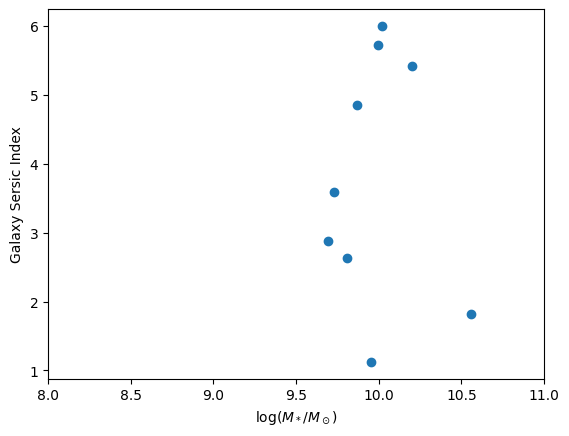

In [99]:
masses = host_tab['MASS'] * u.Msun / cu.littleh ** 2
masses = np.log10(masses.to(u.Msun, cu.with_H0(cosmo.H0)).value)
sersic = host_tab['SERSIC_N']

f, ax = plt.subplots()

ax.scatter(masses, sersic)

ax.set_xlim(8, 11)
ax.set_xlabel("$\log(M_*/M_\odot)$")
ax.set_ylabel("Galaxy Sersic Index")
#sns.jointplot(data= host_tab,x = masses,y = sersic)